<a href="https://colab.research.google.com/github/markvasin/deep_learning_exercise/blob/master/lab8/Lab8_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt

batch_size = 256

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        # YOUR CODE HERE
        self.fc = nn.Linear(input_dim, hidden_dim) 
        

    def forward(self, x):
        # YOUR CODE HERE
        return F.relu(self.fc(x))

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        # YOUR CODE HERE
        self.fc = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        # YOUR CODE HERE
        out = self.fc(x)
        return torch.sigmoid(out)

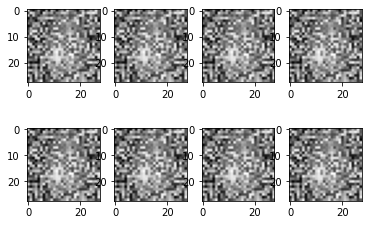

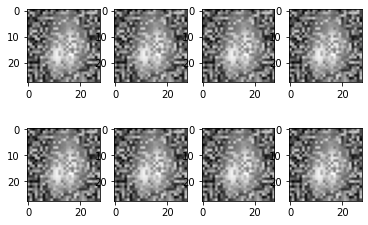

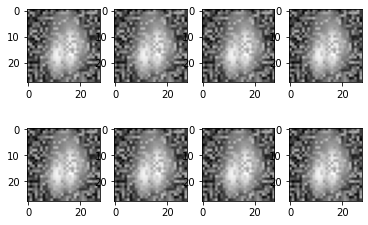

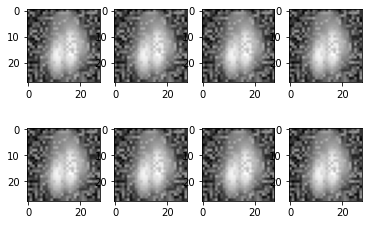

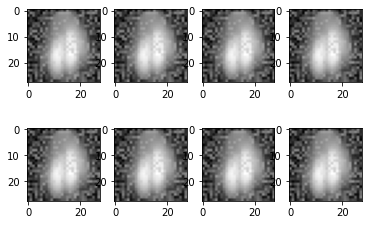

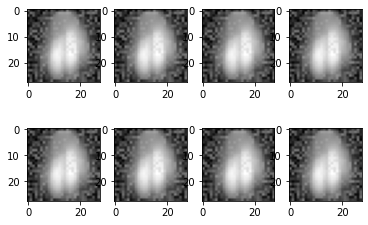

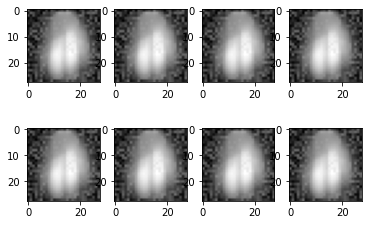

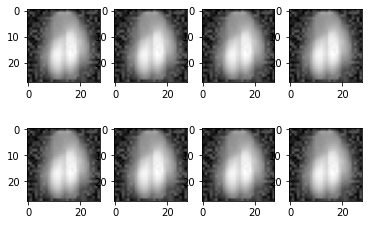

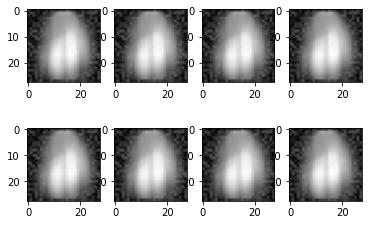

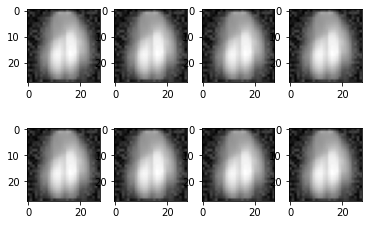

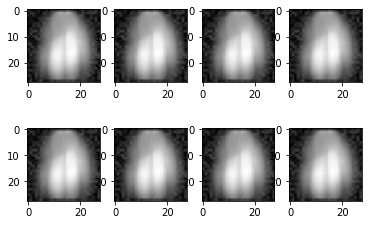

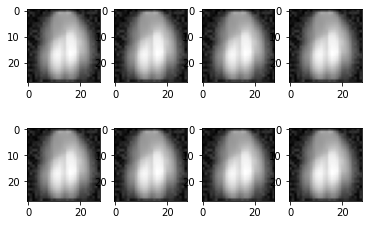

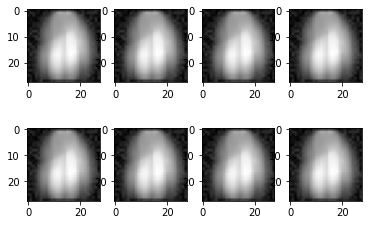

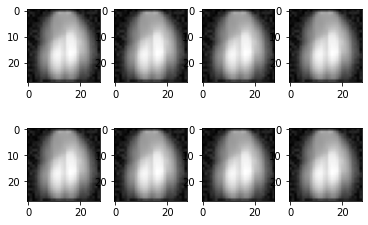

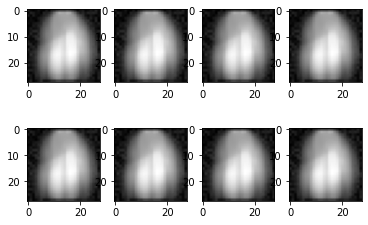

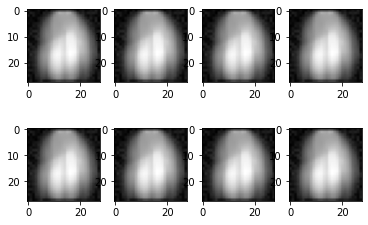

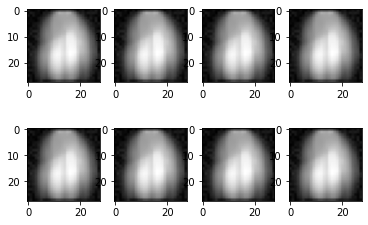

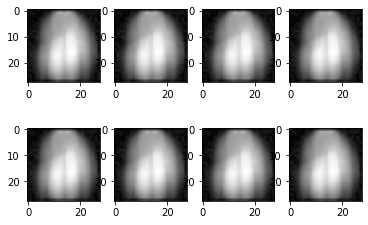

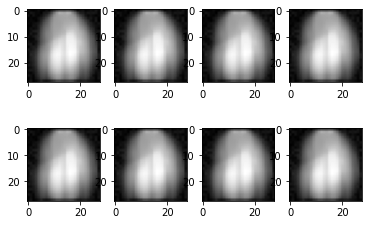

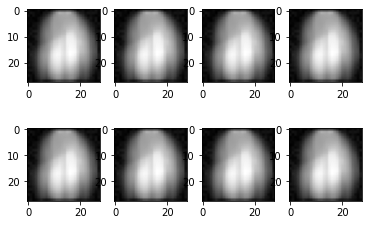

In [ ]:
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

enc_dim = 2
image_dim = 784
nEpoch = 20

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim)
dec = Decoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    
    
    ## Display some of the reconstructed images
    # YOUR CODE HERE
    for i in range(8):
      plt.subplot(int(str(24)+str(i+1)))
      plt.imshow(outputs[i].detach().numpy().reshape((28,28)), cmap=plt.get_cmap('gray'))
    plt.show()

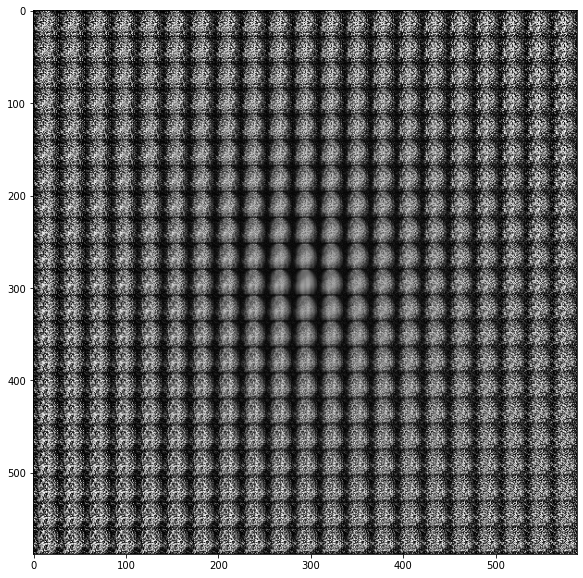

In [ ]:
decoder = dec
n = 21
image_size = 28
figure = np.zeros((image_size * n, image_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = torch.from_numpy(np.array([[xi, yi]])).float()
        x_decoded = decoder(z_sample)
        img = x_decoded.detach().numpy()[0].reshape(image_size, image_size)
        figure[i * image_size: (i + 1) * image_size,
              j * image_size: (j + 1) * image_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap=plt.get_cmap('gray'))
plt.show()